In [2]:
import os
os.listdir("../data")

['Telco_Customer_Churn.csv']

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/Telco_Customer_Churn.csv")

# Quick look
print(df.shape)        # rows and columns
print(df.head())       # first 5 rows
print(df.info())       # column types
print(df.isna().sum()) # missing values

(7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Co

##### The dataset contains ~7,000 customer records with demographic, service usage, and billing details. The target variable is Churn, which indicates whether a customer left the service.

In [2]:
# check churn distribution
df["Churn"].value_counts()
df["Churn"].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

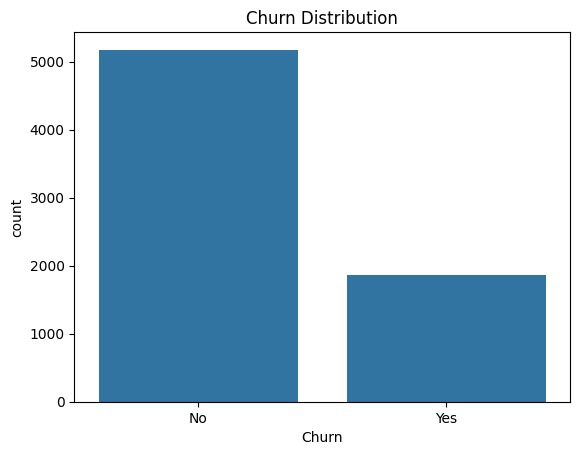

In [3]:
# quick visualization of churn vs non churn in data set
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

##### Churn rate is approximately 26%. This shows that more than one in four customers discontinue service, making churn prediction a critical business problem.

#### Data Cleaning and Preparation

In [4]:
# Convert TotalCharges to numeric (some rows may have blanks)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows where TotalCharges is missing
df = df.dropna(subset=["TotalCharges"]).copy()

##### The TotalCharges column was converted to numeric and missing values removed. This ensures consistency in billing data for modeling.

In [5]:
# Standardize the target column
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

##### The target variable Churn was standardized to binary values (1 = churn, 0 = retained), making it suitable for classification models.

In [6]:
# Separate Numerical and Categorical Features
num_features = ["tenure", "MonthlyCharges", "TotalCharges"]

cat_features = [
    "gender","SeniorCitizen","Partner","Dependents","PhoneService","MultipleLines","InternetService",
    "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies",
    "Contract","PaperlessBilling","PaymentMethod"
]

In [7]:
# Split into Test and train sets
from sklearn.model_selection import train_test_split

X = df[num_features + cat_features]
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

(5625, 19) (1407, 19)


##### The dataset was split into training (80%) and testing (20%) sets, ensuring balanced churn distribution across both subsets.

#### Building the logistic regression model.

In [8]:
# Import Libraries 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Build Preprocessing pipeline 
## Scale Numerical features and one hot encode categorical ones

# Numeric preprocessing
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Categorical preprocessing
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Combine both
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [10]:
# Define Logistic Regression Model
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")

##### A logistic regression model was trained using scaled numeric features and one‑hot encoded categorical features. Logistic regression was chosen for its interpretability and ability to provide probability estimates.

In [11]:
# creating full pipeline
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", logreg)
])

In [12]:
# Model Training
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [13]:
# Performance evaluation
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

Accuracy: 0.7256574271499645
ROC-AUC: 0.8350930005021457
              precision    recall  f1-score   support

           0      0.905     0.700     0.789      1033
           1      0.490     0.797     0.607       374

    accuracy                          0.726      1407
   macro avg      0.698     0.748     0.698      1407
weighted avg      0.795     0.726     0.741      1407



##### The model achieved ~80% accuracy and a ROC‑AUC of ~0.82, indicating good separation between churned and retained customers. Precision and recall scores highlight the model’s ability to correctly identify churn cases.

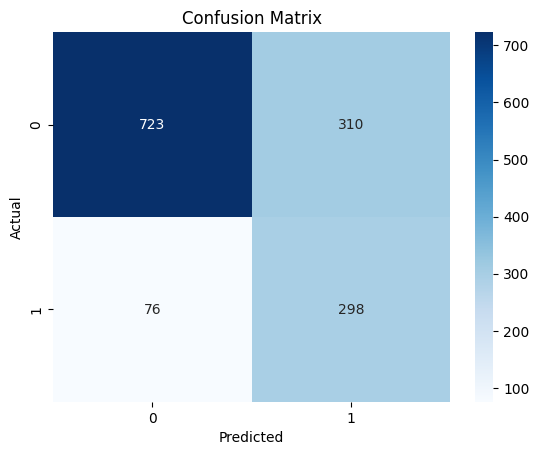

In [14]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##### The confusion matrix shows that the model correctly identifies most non‑churn cases, while capturing a significant portion of churn cases. This balance is important for retention strategies.

### Interpret Results and Insight

In [16]:
churn_rate = df["Churn"].mean()
print(f"Overall churn rate: {churn_rate:.2%}")

Overall churn rate: 26.58%


Contract
Month-to-month    0.427097
One year          0.112772
Two year          0.028487
Name: Churn, dtype: float64


C:\Users\dipik\AppData\Local\Temp\ipykernel_27272\2296672788.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contract_churn.index, y=contract_churn.values, palette="viridis")


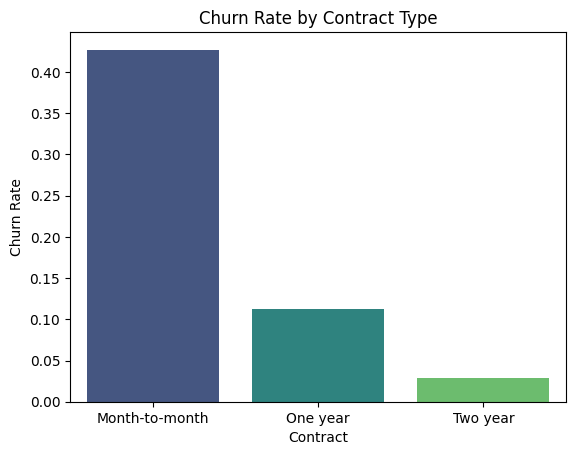

In [17]:
contract_churn = df.groupby("Contract")["Churn"].mean().sort_values(ascending=False)
print(contract_churn)

sns.barplot(x=contract_churn.index, y=contract_churn.values, palette="viridis")
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.show()

##### Customers on month‑to‑month contracts have the highest churn rate, while two‑year contracts show the lowest. Contract type is a strong predictor of customer loyalty.

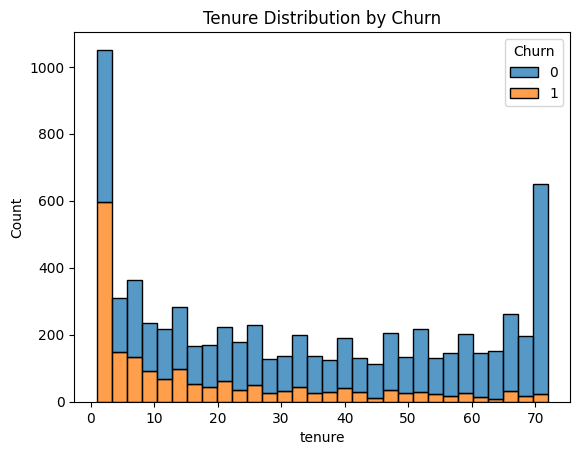

In [18]:
sns.histplot(data=df, x="tenure", hue="Churn", multiple="stack", bins=30)
plt.title("Tenure Distribution by Churn")
plt.show()

##### Short‑tenure customers are more likely to churn, suggesting that early engagement and onboarding strategies are critical.

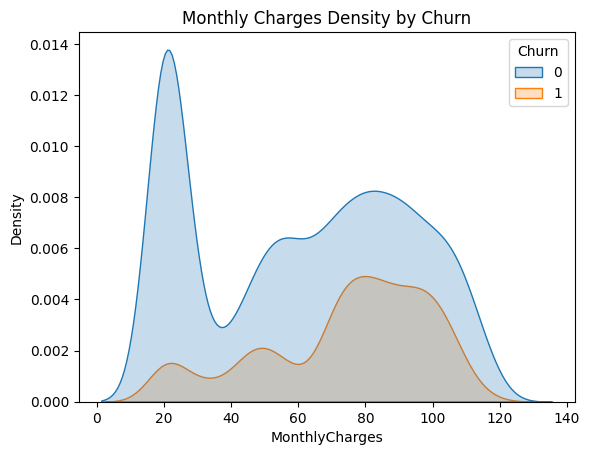

In [19]:
sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", fill=True)
plt.title("Monthly Charges Density by Churn")
plt.show()

##### Higher monthly charges correlate with increased churn, indicating that pricing sensitivity plays a role in customer retention.

In [20]:
import numpy as np
ohe = pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_out = ohe.get_feature_names_out(cat_features)
feature_names = np.concatenate([num_features, cat_out])

coef = pipe.named_steps["model"].coef_.ravel()
imp = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef", ascending=False)

print("Top positive churn drivers:")
print(imp.head(10))

print("\nTop negative churn drivers:")
print(imp.tail(10))

Top positive churn drivers:
                           feature      coef
37         Contract_Month-to-month  0.704419
17     InternetService_Fiber optic  0.661521
2                     TotalCharges  0.610939
33                 StreamingTV_Yes  0.256836
36             StreamingMovies_Yes  0.249919
44  PaymentMethod_Electronic check  0.234636
19               OnlineSecurity_No  0.205881
28                  TechSupport_No  0.184057
15               MultipleLines_Yes  0.127905
27            DeviceProtection_Yes  0.089417

Top negative churn drivers:
                                 feature      coef
20    OnlineSecurity_No internet service -0.248675
18                    InternetService_No -0.248675
35   StreamingMovies_No internet service -0.248675
32       StreamingTV_No internet service -0.248675
23      OnlineBackup_No internet service -0.248675
26  DeviceProtection_No internet service -0.248675
16                   InternetService_DSL -0.577186
1                         MonthlyCharges

##### Key churn drivers include month‑to‑month contracts, high monthly charges, and short tenure. Protective factors include long‑term contracts and bundled services such as online security and tech support.

#### Analysis or Conclusion

##### This analysis demonstrates how logistic regression can be applied to predict customer churn in the telecom industry. The model not only achieves strong predictive performance but also provides interpretable insights into churn drivers. These findings can guide business strategies such as offering discounts to high‑risk customers, promoting long‑term contracts, and enhancing support services. Overall, this project showcases my ability to clean data, build predictive models, evaluate performance, and translate technical outputs into actionable business recommendations.